In [7]:
import sympy as sp
import numpy as np
from scipy import optimize
import sys

sys.path.append("..")

from cge_modeling.sympy_tools import info_to_symbols, enumerate_indexbase, sub_all_eqs
from cge_modeling.production_functions import leontief, cobb_douglass
from cge_modeling.base.cge import (
    compile_cge_to_numba,
    expand_compact_system,
    recursive_solve_symbolic,
    numba_linearize_cge_func,
)
from cge_modeling.numba_tools import euler_approx

import pandas as pd

In [8]:
def symbol(name, *sectors):
    if sectors == ():
        return sp.Symbol(name, **default_assumptions)
    suffix = "_" + "_".join(sectors)
    return sp.Symbol(f"{name}{suffix}", **default_assumptions)


def symbols(name, value, sectors):
    return {symbol(name, sector): value for sector in sectors}


def remove_string_keys(d):
    d_copy = d.copy()
    for k in d:
        if isinstance(k, str):
            del d_copy[k]
    return d_copy

# Data

In [9]:
df = pd.read_csv("data/lesson_3_sam.csv", index_col=[0, 1], header=[0, 1]).applymap(float).fillna(0)
assert np.allclose(df.sum(axis=0), df.sum(axis=1))
df

/var/folders/7b/rzxy96cj0w751_6td3g2yss00000gn/T/ipykernel_98911/3583921827.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = pd.read_csv("data/lesson_3_sam.csv", index_col=[0, 1], header=[0, 1]).applymap(float).fillna(0)


Factor         Institution                  \
                          Labor Capital   Household   Firms    Govt   
Factor      Labor           0.0     0.0         0.0     0.0     0.0   
            Capital         0.0     0.0         0.0     0.0     0.0   
Institution Household    7200.0     0.0         0.0  2800.0     0.0   
            Firms           0.0  2800.0         0.0     0.0     0.0   
            Govt            0.0     0.0      3700.0     0.0     0.0   
Production  Agriculture     0.0     0.0      1700.0     0.0   400.0   
            Industry        0.0     0.0      1200.0     0.0  1500.0   
            Services        0.0     0.0      3400.0     0.0  2300.0   
Activities  Agriculture     0.0     0.0         0.0     0.0     0.0   
            Industry        0.0     0.0         0.0     0.0     0.0   
            Services        0.0     0.0         0.0     0.0     0.0   

                         Production                    Activities           \
                        Agriculture Industry Services Agriculture Industry   
Factor      Labor               0.0      0.0      0.0      1300.0   1900.0   
            Capital             0.0      0.0      0.0       200.0   2100.0   
Institution Household           0.0      0.0      0.0         0.0      0.0   
            Firms               0.0      0.0      0.0         0.0      0.0   
            Govt              100.0    220.0    180.0         0.0      0.0   
Production  Agriculture         0.0      0.0      0.0      1000.0   1000.0   
            Industry            0.0      0.0      0.0      2010.0   3510.0   
            Services            0.0      0.0      0.0       490.0   2490.0   
Activities  Agriculture      5000.0      0.0      0.0         0.0      0.0   
            Industry            0.0  11000.0      0.0         0.0      0.0   
            Services            0.0      0.0   9500.0         0.0      0.0   

                                  
                        Services  
Factor      Labor         4000.0  
            Capital        500.0  
Institution Household        0.0  
            Firms            0.0  
            Govt             0.0  
Production  Agriculture   1000.0  
            Industry      3000.0  
            Services      1000.0  
Activities  Agriculture      0.0  
            Industry         0.0  
            Services         0.0

# Preliminaries

In [10]:
default_assumptions = {"real": True}
sectors = ["Ag", "Ind", "Serv"]
i, j = [sp.Idx(name) for name in list("ij")]
index_dict = {i: sectors, j: sectors}

In [11]:
var_info = [
    ("Y", (i,)),
    ("VA", (i,)),
    ("IC", (i,)),
    ("CIJ", (i, j)),
    ("C", (i,)),
    ("C_G", (i,)),
    ("Ld", (i,)),
    ("Kd", (i,)),
    ("P", (i,)),
    ("P_VA", (i,)),
    ("P_IC", (i,)),
    ("P_Y", (i,)),
    ("sales_tax", (i,)),
    ("income_tax", ()),
    ("U", ()),
    ("r", ()),
    ("w", ()),
    ("income", ()),
    ("net_income", ()),
    ("G", ()),
    ("walras_resid", ()),
]

variables = info_to_symbols(var_info, default_assumptions)
(
    Y,
    VA,
    IC,
    CIJ,
    C,
    C_G,
    Ld,
    Kd,
    P,
    P_VA,
    P_IC,
    P_Y,
    sales_tax,
    income_tax,
    U,
    r,
    w,
    income,
    net_income,
    G,
    walras_resid,
) = variables

In [12]:
param_info = [
    ("psi_VA", (i,)),
    ("psi_IC", (i,)),
    ("psi_CIJ", (i, j)),
    ("alpha", (i,)),
    ("alpha_G", (i,)),
    ("tau", (i,)),
    ("gamma", (i,)),
    ("A", (i,)),
    ("Ls", ()),
    ("Ks", ()),
    ("tau_income", ()),
    ("P_Ag_bar", ()),
]

parameters = info_to_symbols(param_info, default_assumptions)
(
    psi_VA,
    psi_IC,
    psi_CIJ,
    alpha,
    alpha_G,
    tau,
    gamma,
    A,
    Ls,
    Ks,
    tau_income,
    P_Ag_bar,
) = parameters

In [15]:
final_goods_block = leontief(Y, P_Y, [IC, VA], [P_IC, P_VA], [psi_IC, psi_VA])
value_add_block = cobb_douglass(VA, P_VA, A, [Kd, Ld], [r, w], [alpha])

# Need to change how indexing is done in the intermediate block, because the model flips the indices for these equations
# So need to make some dummy variables
inter_names = ["P_IC", "IC", "P", "CIJ", "psi_CIJ", "IC"]
P_IC2, IC2, P2, CIJ2, psi_CIJ2, IC2 = [
    sp.IndexedBase(name, **default_assumptions) for name in inter_names
]

intermediate_goods_block = [
    P_IC2[j] * IC2[j] - sp.Sum(P2[i] * CIJ2[i, j], (i, 0, 2)).doit(),
    CIJ2[i, j] - psi_CIJ2[i, j] * IC2[j],
]

other_equations = [
    # Income block
    income - w * Ls - r * Ks,
    net_income - (1 - tau_income) * income,
    income_tax - (income - net_income),
    # Household demand block
    U - sp.Product(C**gamma, (i, 0, 2)).doit(),
    gamma * net_income - P * C,
    # Government block
    tau_income * income + sp.Sum(tau * P_Y * Y, (i, 0, 2)).doit() - G,
    P * C_G - alpha_G * G,
    # Definiton of tax rates
    tau - sales_tax / (Y - sales_tax),
    # Price level
    P - P_Y * (1 + tau),
    # Market Equlibrium
    Ls - sp.Sum(Ld, (i, 0, 2)).doit() - walras_resid,
    Ks - sp.Sum(Kd, (i, 0, 2)).doit(),
    C + sp.Sum(CIJ, (j, 0, 2)).doit() + C_G - Y,
    # Numeraire
    P.subs({i: 0}) - P_Ag_bar,
]

equations = final_goods_block + value_add_block + intermediate_goods_block + other_equations

In [6]:
for eq in equations:
    display(eq)

-IC[i]*P_IC[i] - P_VA[i]*VA[i] + P_Y[i]*Y[i]

IC[i] - Y[i]*psi_IC[i]

VA[i] - Y[i]*psi_VA[i]

-A[i]*Kd[i]**alpha[i]*Ld[i]**(1 - alpha[i]) + VA[i]

Kd[i] - P_VA[i]*VA[i]*alpha[i]/r

Ld[i] - (1 - alpha[i])*P_VA[i]*VA[i]/w

-CIJ[0, j]*P[0] - CIJ[1, j]*P[1] - CIJ[2, j]*P[2] + IC[j]*P_IC[j]

CIJ[i, j] - IC[j]*psi_CIJ[i, j]

-Ks*r - Ls*w + income

-income*(1 - tau_income) + net_income

-income + income_tax + net_income

U - C[0]**gamma[0]*C[1]**gamma[1]*C[2]**gamma[2]

net_income*gamma[i] - C[i]*P[i]

-G + income*tau_income + P_Y[0]*Y[0]*tau[0] + P_Y[1]*Y[1]*tau[1] + P_Y[2]*Y[2]*tau[2]

-G*alpha_G[i] + C_G[i]*P[i]

tau[i] - sales_tax[i]/(Y[i] - sales_tax[i])

-(tau[i] + 1)*P_Y[i] + P[i]

Ls - walras_resid - Ld[0] - Ld[1] - Ld[2]

Ks - Kd[0] - Kd[1] - Kd[2]

CIJ[i, 0] + CIJ[i, 1] + CIJ[i, 2] + C[i] + C_G[i] - Y[i]

-P_Ag_bar + P[0]

# Calibration

In [16]:
df

Factor         Institution                  \
                          Labor Capital   Household   Firms    Govt   
Factor      Labor           0.0     0.0         0.0     0.0     0.0   
            Capital         0.0     0.0         0.0     0.0     0.0   
Institution Household    7200.0     0.0         0.0  2800.0     0.0   
            Firms           0.0  2800.0         0.0     0.0     0.0   
            Govt            0.0     0.0      3700.0     0.0     0.0   
Production  Agriculture     0.0     0.0      1700.0     0.0   400.0   
            Industry        0.0     0.0      1200.0     0.0  1500.0   
            Services        0.0     0.0      3400.0     0.0  2300.0   
Activities  Agriculture     0.0     0.0         0.0     0.0     0.0   
            Industry        0.0     0.0         0.0     0.0     0.0   
            Services        0.0     0.0         0.0     0.0     0.0   

                         Production                    Activities           \
                        Agriculture Industry Services Agriculture Industry   
Factor      Labor               0.0      0.0      0.0      1300.0   1900.0   
            Capital             0.0      0.0      0.0       200.0   2100.0   
Institution Household           0.0      0.0      0.0         0.0      0.0   
            Firms               0.0      0.0      0.0         0.0      0.0   
            Govt              100.0    220.0    180.0         0.0      0.0   
Production  Agriculture         0.0      0.0      0.0      1000.0   1000.0   
            Industry            0.0      0.0      0.0      2010.0   3510.0   
            Services            0.0      0.0      0.0       490.0   2490.0   
Activities  Agriculture      5000.0      0.0      0.0         0.0      0.0   
            Industry            0.0  11000.0      0.0         0.0      0.0   
            Services            0.0      0.0   9500.0         0.0      0.0   

                                  
                        Services  
Factor      Labor         4000.0  
            Capital        500.0  
Institution Household        0.0  
            Firms            0.0  
            Govt             0.0  
Production  Agriculture   1000.0  
            Industry      3000.0  
            Services      1000.0  
Activities  Agriculture      0.0  
            Industry         0.0  
            Services         0.0

In [17]:
short_to_long = {"Ag": "Agriculture", "Ind": "Industry", "Serv": "Services"}

# Normalize prices
initial_values = {w: 1, r: 1, walras_resid: 0}
initial_values.update(symbols("P_VA", 1, sectors))
initial_values.update(symbols("P_IC", 1, sectors))
initial_values.update(symbols("P_Y", 1, sectors))

# Enter data from SAM
initial_values[income_tax] = df.loc[("Institution", "Govt"), ("Institution", "Household")]
for sector in sectors:
    long_sector = short_to_long[sector]
    initial_values[symbol("Ld", sector)] = (
        df.loc[("Factor", "Labor"), ("Activities", long_sector)] / initial_values[w]
    )
    initial_values[symbol("Kd", sector)] = (
        df.loc[("Factor", "Capital"), ("Activities", long_sector)] / initial_values[r]
    )
    initial_values[symbol("C_G", sector)] = df.loc[
        ("Production", long_sector), ("Institution", "Govt")
    ]
    initial_values[symbol("sales_tax", sector)] = df.loc[
        ("Institution", "Govt"), ("Production", long_sector)
    ]
    initial_values[symbol("C", sector)] = df.loc[
        ("Production", long_sector), ("Institution", "Household")
    ]
    initial_values[symbol("Y", sector)] = df.sum(axis=0).loc[("Production", long_sector)]

    # Work out the tax rate from tax reciepts
    tax_rate = symbol("tau", sector)
    P_sector = symbol("P", sector)

    sector_tax_paid = initial_values[symbol("sales_tax", sector)]

    initial_values[tax_rate] = sector_tax_paid / (
        initial_values[symbol("Y", sector)] - sector_tax_paid
    )
    initial_values[P_sector] = initial_values[symbol("P_Y", sector)] * (
        1 + initial_values[tax_rate]
    )

    # Adjust values in SAM to account for non-normalized prices
    P_adj = initial_values[P_sector]
    for sector_j in sectors:
        long_sector_j = short_to_long[sector_j]
        SAM_idx = ("Production", long_sector), ("Activities", long_sector_j)
        initial_values[symbol("CIJ", sector, sector_j)] = df.loc[SAM_idx] / P_adj

    demands_to_adjust = ["C", "C_G", "Y"]
    for demand in demands_to_adjust:
        initial_values[symbol(demand, sector)] = initial_values[symbol(demand, sector)] / P_adj

# Known aggregates
# Have to do this because income tax reciepts aren't a model equaiton. Very strange!
initial_values[symbol("Ls")] = sum(
    [initial_values[k] for k in initial_values.keys() if getattr(k, "name", "").startswith("Ld_")]
)
initial_values[symbol("Ks")] = sum(
    [initial_values[k] for k in initial_values.keys() if getattr(k, "name", "").startswith("Kd_")]
)

initial_values[income] = (
    initial_values[w] * initial_values[Ls] + initial_values[r] * initial_values[Ks]
)
initial_values[tau_income] = initial_values[income_tax] / initial_values[income]
initial_values[net_income] = (1 - initial_values[tau_income]) * initial_values[income]

initial_values = remove_string_keys(initial_values)

In [18]:
initial_values

{w: 1,
 r: 1,
 walras_resid: 0,
 P_VA_Ag: 1,
 P_VA_Ind: 1,
 P_VA_Serv: 1,
 P_IC_Ag: 1,
 P_IC_Ind: 1,
 P_IC_Serv: 1,
 P_Y_Ag: 1,
 P_Y_Ind: 1,
 P_Y_Serv: 1,
 income_tax: 3700.0,
 Ld_Ag: 1300.0,
 Kd_Ag: 200.0,
 C_G_Ag: 392.156862745098,
 sales_tax_Ag: 100.0,
 C_Ag: 1666.6666666666667,
 Y_Ag: 5000.0,
 tau_Ag: 0.02,
 P_Ag: 1.02,
 CIJ_Ag_Ag: 980.3921568627451,
 CIJ_Ag_Ind: 980.3921568627451,
 CIJ_Ag_Serv: 980.3921568627451,
 Ld_Ind: 1900.0,
 Kd_Ind: 2100.0,
 C_G_Ind: 1470.5882352941176,
 sales_tax_Ind: 220.0,
 C_Ind: 1176.4705882352941,
 Y_Ind: 11000.0,
 tau_Ind: 0.02,
 P_Ind: 1.02,
 CIJ_Ind_Ag: 1970.5882352941176,
 CIJ_Ind_Ind: 3441.176470588235,
 CIJ_Ind_Serv: 2941.176470588235,
 Ld_Serv: 4000.0,
 Kd_Serv: 500.0,
 C_G_Serv: 2257.2314049586776,
 sales_tax_Serv: 180.0,
 C_Serv: 3336.7768595041325,
 Y_Serv: 9500.0,
 tau_Serv: 0.018947368421052633,
 P_Serv: 1.0189473684210526,
 CIJ_Serv_Ag: 480.88842975206614,
 CIJ_Serv_Ind: 2443.698347107438,
 CIJ_Serv_Serv: 981.404958677686,
 Ls: 7200.0,
 Ks

In [19]:
long_system, named_variables, named_params = expand_compact_system(
    compact_equations=equations,
    compact_variables=variables,
    compact_params=parameters,
    index_dict=index_dict,
)

In [20]:
state_0 = recursive_solve_symbolic(long_system, initial_values)
numeraire = symbol("P", "Ag")
numeraire_dict = {P.subs({i: 0}): state_0[numeraire]}

x0 = np.array([state_0[k] for k in named_variables if k != numeraire], dtype=float)
theta0 = np.array([state_0[x] for x in named_params], dtype=float)

In [26]:
for k in sorted(list(state_0.keys()), key=lambda x: x.name):
    print(f"{k.name:<25}{state_0[k]:0.5f}")

A_Ag                     1.48094
A_Ind                    1.99750
A_Serv                   1.41741
CIJ_Ag_Ag                980.39216
CIJ_Ag_Ind               980.39216
CIJ_Ag_Serv              980.39216
CIJ_Ind_Ag               1970.58824
CIJ_Ind_Ind              3441.17647
CIJ_Ind_Serv             2941.17647
CIJ_Serv_Ag              480.88843
CIJ_Serv_Ind             2443.69835
CIJ_Serv_Serv            981.40496
C_Ag                     1666.66667
C_G_Ag                   392.15686
C_G_Ind                  1470.58824
C_G_Serv                 2257.23140
C_Ind                    1176.47059
C_Serv                   3336.77686
G                        4200.00000
IC_Ag                    3500.00000
IC_Ind                   7000.00000
IC_Serv                  5000.00000
Kd_Ag                    200.00000
Kd_Ind                   2100.00000
Kd_Serv                  500.00000
Ks                       2800.00000
Ld_Ag                    1300.00000
Ld_Ind                   1900.00000
Ld_Serv  

In [29]:
loss_funcs, system_funcs, ordered_inputs = compile_cge_to_numba(
    compact_equations=equations,
    compact_variables=variables,
    compact_params=parameters,
    index_dict=index_dict,
    numeraire_dict={},
)
f_resid, f_grad, f_hess = loss_funcs
f_system, f_jac = system_funcs

In [33]:
f_resid(x0, theta0)

array(4.67103878e-07)

In [35]:
tax_reform = state_0.copy()
tax_reform[tau_income] = tax_reform[tau_income] * 0.9
calibrated_params = np.array([tax_reform[x] for x in ordered_inputs[1]], dtype=float)

tax_reform_res = optimize.minimize(
    f_resid,
    x0,
    args=calibrated_params,
    jac=f_grad,
    hess=f_hess,
    method="trust-exact",
    options=dict(maxiter=1_000_000),
    tol=1e-5,
)
tax_reform_res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 8.172801161042592e-16
       x: [ 5.072e+03  1.095e+04 ...  3.830e+03  3.425e-04]
     nit: 142
     jac: [-1.091e-12  3.660e-12 ... -2.183e-11  0.000e+00]
    nfev: 143
    njev: 102
    nhev: 143
    hess: [[ 5.161e+00  7.996e-04 ... -4.000e-02  0.000e+00]
           [ 7.996e-04  5.073e+00 ... -3.998e-02  0.000e+00]
           ...
           [-4.000e-02 -3.998e-02 ...  2.873e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  2.000e+00]]

In [36]:
scenario_df = pd.DataFrame(
    np.c_[x0, tax_reform_res.x],
    index=[x.name for x in ordered_inputs[0]],
    columns=["initial", "income_tax_cut"],
)

scenario_df = scenario_df.assign(impact=lambda x: x.income_tax_cut / x.initial - 1)

<Axes: >

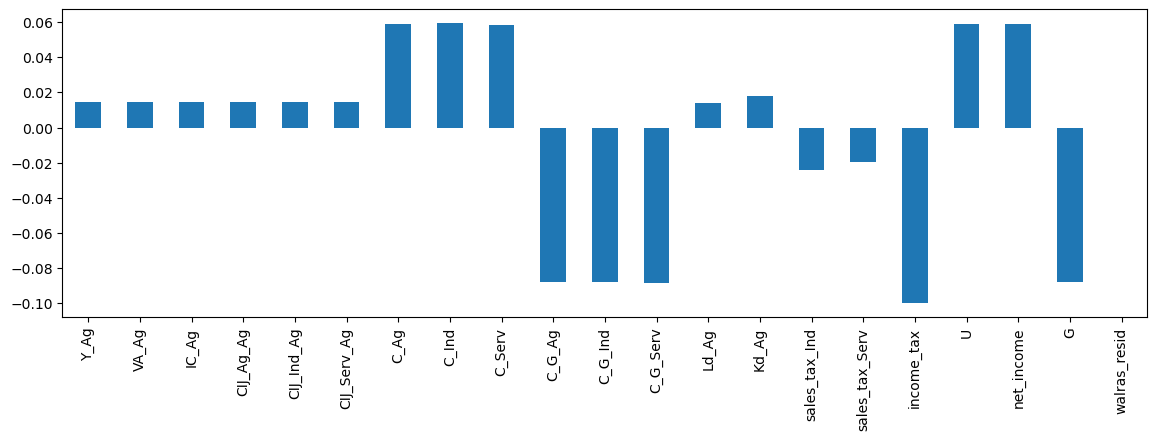

In [40]:
scenario_df.impact.loc[lambda x: abs(x) > 1e-2].plot.bar(figsize=(14, 4))

## Linear Approximation

In [43]:
f_dX = numba_linearize_cge_func(equations, variables, parameters, index_dict)

In [65]:
tax_reform = state_0.copy()
tax_reform[tau_income] = tax_reform[tau_income] * 0.9
theta_tax_reform = np.array([tax_reform[x] for x in ordered_inputs[1]], dtype=float)
tax_reform_scenario = euler_approx(f_dX, x0, theta0, theta_tax_reform, 100_000)

In [66]:
n_params = len(named_params)
scenario_df_linear = pd.DataFrame(
    np.c_[x0, tax_reform_scenario[:-n_params]],
    index=[x.name for x in ordered_inputs[0]],
    columns=["initial", "income_tax_cut"],
)
scenario_df_linear = scenario_df_linear.assign(impact=lambda x: x.income_tax_cut / x.initial - 1)

In [67]:
(
    pd.merge(
        scenario_df.income_tax_cut,
        scenario_df_linear.income_tax_cut,
        left_index=True,
        right_index=True,
    ).round(2)
)

,income_tax_cut_x,income_tax_cut_y
Y_Ag,5072.29,5072.29
Y_Ind,10951.54,10951.54
Y_Serv,9491.38,9491.38
VA_Ag,1521.69,1521.69
VA_Ind,3982.38,3982.38
VA_Serv,4495.92,4495.92
IC_Ag,3550.61,3550.61
IC_Ind,6969.16,6969.16
IC_Serv,4995.47,4995.47
CIJ_Ag_Ag,994.57,994.57


<Axes: >

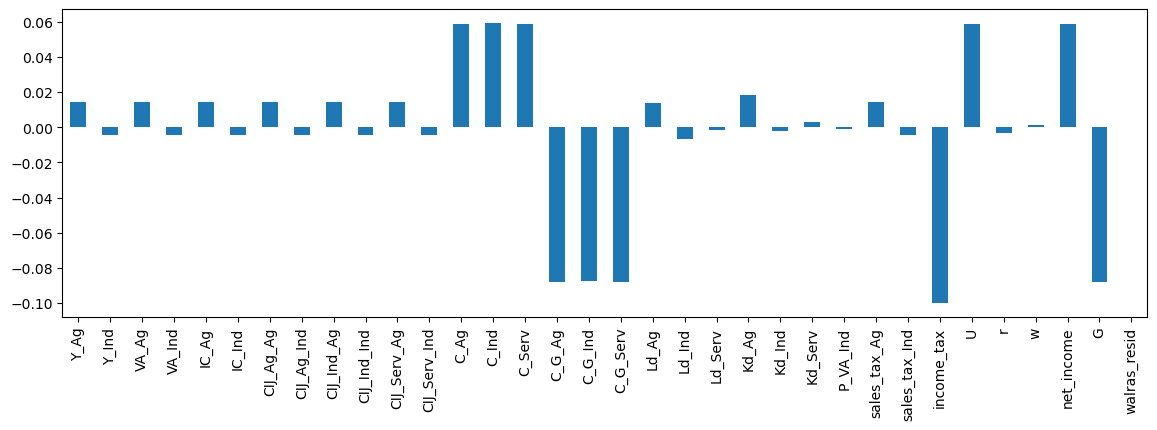

In [70]:
scenario_df_linear.impact.loc[lambda x: abs(x) > 1e-3].plot.bar(figsize=(14, 4))